<h1>Getting Started</h1>

In [1]:
# if you are running in the notebooks folder example cloned from github this line must be included
import sys
import os
sys.path.insert(0, os.path.abspath('../'))



<h3>Import CtllDes and poliastro, the core and utils elements </h3>

In [2]:
import numpy as np

#Propagator engine
import poliastro

#The library
import CtllDes 
from CtllDes.core import ctll, satellite

#Throughout this examples it will be necessary to use the correct
#physical dimensions, astropy.units will help us with that
import astropy.units as u

# Building an orbit 

The first step is to define an orbit. You can do this in a variety of ways as showed below.

### Building from classical orbit parameters

In [3]:
#Orbit object, more info on poliastro API reference.
from poliastro.twobody import Orbit

#The bodies module specifies attractors
from poliastro.bodies import Earth


#Planes of reference and Epochs, are almost every time 
#the default ones, but just in case if you want to use 
#any other, they can be found in the following modules

#import planes of reference, EARTH_EQUATOR 
from poliastro.frames import Planes

#import J2000 time reference from constants 
from poliastro.constants import J2000



### Specify classical orbit parameters ###

a = 8000 * u.km # semi-major axis [distance]
ecc = 0 * u.one # eccentricity [dimensionleess]
inc = 98 * u.deg # inclination [angle] 
raan = 0 * u.rad # right ascencion of the ascending node [angle]
argp = 0 * u.rad # perigee argument [angle]
nu = 0 * u.rad # true anomaly [angle]

plane = Planes.EARTH_EQUATOR # not necessary to specify
epoch = J2000 # not necessary to specify

#classmethod of Orbit
orb = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            raan,
                            argp,
                            nu)


### Other poliastro.twobody.Orbit classmethods

In [4]:
#more on poliastro API reference
orb = Orbit.heliosynchronous(Earth, a=8000*u.km, ecc=0*u.one)
orb = Orbit.from_vectors(Earth, [8000,0,0]*u.km, [0,7,0]*u.km/u.s)

### Orbit utilities for repeating ground track and heliosynchronous orbits

In [5]:
from CtllDes.utils import sscalc

D = 7 #days of revisit
orb_df = sscalc.helio_rgt_synchronous(D) #dataframe
orb_df #radius [km], inclination [degrees], revolutions per day.

,radius,inc,N
0,11544.182918,142.248541,7.000000
1,11389.626716,138.961424,7.142857
2,11240.148578,136.071863,7.285714
3,11095.486092,133.496401,7.428571
4,10955.395204,131.177130,7.571429
...,...,...,...
66,6535.898060,96.204172,16.428571
67,6498.279346,96.079672,16.571429
68,6461.197311,95.958727,16.714286
69,6424.639809,95.841203,16.857143


In [6]:
#use pandas to filter the desired parameters
earth_R = Earth.R_mean.to(u.km).value #value in km of earth mean Radius

min_radius = 500 + earth_R
max_radius = 900 + earth_R

filtered = orb_df.loc[(orb_df['radius'].values < max_radius) &
                      (orb_df['radius'].values > min_radius)]
filtered 

,radius,inc,N
50,7222.422363,98.816646,14.142857
51,7174.189097,98.610796,14.285714
52,7126.753168,98.411801,14.428571
53,7080.093692,98.219362,14.571429
54,7034.190529,98.033200,14.714286
55,6989.024251,97.853046,14.857143
56,6944.576109,97.678649,15.000000
57,6900.828006,97.509769,15.142857


In [7]:
#select the desired cop, i.e. classical orbit parameters
cop = filtered.loc[55] #pick one from the df
a = cop['radius']*u.km #radius = semi-major axis
ecc = 0 * u.one # this is cant be different than 0 since the helio_rgt is for circular orbits
inc = cop['inc']*u.deg

#reuse past raan, argp and nu
orb = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            raan,
                            argp,
                            nu)

# Building satellites

 Satellite is one of the main classes in this library. You can build a satellite reading the docs, you are encouraged to use the classmethods.


In [8]:
from CtllDes.core.satellite import Sat


### Building satellite from classmethods.

In [9]:
sat = Sat.from_orbit(orb) 
sat = Sat.from_vectors([8000,0,0]*u.km,
                       [0,7,0]*u.km/u.s,
                      attractor=Earth)


# Satellite's parameters 

In [10]:
sat.info() #general info at t=0

id : 6d1f4906-3123-4230-8cfa-3b4f0ee59fed	[a ecc inc raan argp nu] : [7869.7 km 0.0 0.0 rad 0.0 rad 3.1 rad -3.1 rad]		status : Online


### Physical Specifications

In [11]:
print(sat.spec) #None specified, default parameters selected

 m:1.0 kg, Cd:1.0, A:1.0 m2


### Status

In [12]:
sat.status #None specified, Online status 

'Online'

### Instruments

In [13]:
sat.instruments #None specified, empty list

[]

### Universal Unique Identfier


In [14]:
sat.id

UUID('6d1f4906-3123-4230-8cfa-3b4f0ee59fed')

### Attractor

In [15]:
sat.attractor

Earth (♁)

### Orbit

In [16]:
sat.orbit

7739 x 8000 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)

#  Physical Specifications

In [17]:
from CtllDes.core import specs

In [18]:

drag_coef = 2.2*u.one
mass = 200*u.kg
Area = 10*u.m**2

spec = specs.Specifications(m=mass, Cd=drag_coef, A=Area)

In [19]:
sat.update_spec(spec)
print(sat.spec)

 m:200.0 kg, Cd:2.2, A:10.0 m2


#  Status (in dev)

In [20]:
#In development. Until now is just a string identifying if the 
#satellite is Online or not. This will impact when calculating
#merit figures. 

In [21]:
sat.update_status('Shutoff')
sat.status

Warning, notImplemented


'Online'

# Instruments

The instruments module is explained in more detailed in instruments.ipynb. There you can find how to create new instruments and For now, the example below will just update the instrument with a default Camera one. 

In [22]:
from CtllDes.core import instrument

In [23]:
camera = instrument.Camera(800, 0.01) # pixels, angle resolution
sat.update_instruments(camera,f=True) # force option
sat.instruments

# Building a Constellation

In [24]:
#since a constellation is a set of satellite we will build a few more.

sat0 = sat
sat1 = Sat.from_vectors([8000,0,0]*u.km,
                        [0,7,0]*u.km/u.s,
                        attractor=Earth)
sat2 = Sat.from_orbit(Orbit.heliosynchronous(Earth,
                                             a=8000*u.km,
                                             ecc=0*u.one))


In [25]:
constellation = ctll.Ctll.from_sats([sat0,sat1,sat2])

In [26]:
constellation.info()


3 satellites within no Pattern


In [27]:
constellation.info(v=True)


3 satellites in no Pattern

id : 29d936dd-0c4d-4384-b0e7-9631b6c33c1a	[a ecc inc raan argp nu] : [7869.7 km 0.0 0.0 rad 0.0 rad 3.1 rad -3.1 rad]		status : Online
id : afe6eba3-9390-41be-b2aa-da05992b49f1	[a ecc inc raan argp nu] : [7869.7 km 0.0 0.0 rad 0.0 rad 3.1 rad -3.1 rad]		status : Online
id : 7c9d985f-34f9-4154-b6d9-43755fc66ae8	[a ecc inc raan argp nu] : [8000.0 km 0.0 1.8 rad 610.5 deg 0.0 deg 0.0 deg]		status : Online


In [28]:
ids = constellation.online_id
ids 

[UUID('29d936dd-0c4d-4384-b0e7-9631b6c33c1a'),
 UUID('afe6eba3-9390-41be-b2aa-da05992b49f1'),
 UUID('7c9d985f-34f9-4154-b6d9-43755fc66ae8')]

In [29]:
sat_by_id = constellation.get_sat(ids[1])
sat_by_id.info()

id : afe6eba3-9390-41be-b2aa-da05992b49f1	[a ecc inc raan argp nu] : [7869.7 km 0.0 0.0 rad 0.0 rad 3.1 rad -3.1 rad]		status : Online


In [30]:
constellation.sats[1].info()

id : afe6eba3-9390-41be-b2aa-da05992b49f1	[a ecc inc raan argp nu] : [7869.7 km 0.0 0.0 rad 0.0 rad 3.1 rad -3.1 rad]		status : Online


In [31]:
constellation.instruments

[[<CtllDes.core.instrument.Camera at 0x7f2c72f5a8e0>], [], []]

In [32]:
camera1 = instrument.Camera(800,0.1)
camera2 = instrument.Camera(800,0.04)

In [33]:
#this wouldnt work since the constellation copies the sat info
sat1.update_instruments(camera1,f=True)
sat2.update_instruments(camera2,f=True)

constellation.instruments

[[<CtllDes.core.instrument.Camera at 0x7f2c72f5a8e0>], [], []]

In [34]:
constellation.sats[1].update_instruments(camera1,f=True)
constellation.sats[2].update_instruments(camera2,f=True)

constellation.instruments

[[<CtllDes.core.instrument.Camera at 0x7f2c72f5a8e0>],

### Building specific pattern 

In [35]:
#Build a Walker Delta constellation
T = 10
P = 5
F = 3

p = 12000*u.km
ecc = 0*u.one
inc = 99*u.deg
raan = 30*u.deg
argp = 20*u.deg
nu = 0.3*u.rad

WDctll = ctll.Ctll.from_WalkerDelta(T,
                                    P,
                                    F,
                                    p,
                                    ecc,
                                    inc,
                                    argp,
                                    raan_offset=raan,
                                    nu_offset=nu,
                                   )

In [36]:
WDctll.info(v=True)


10 satellites in Walker Delta Pattern T/P/F = 10/5/3

id : ee6f7b79-63bf-4bf3-a75e-545c11dbf65f	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 30.0 deg 20.0 deg 17.2 deg]		status : Online
id : fddd6840-fe35-467f-b6b7-eafb4ec97129	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 30.0 deg 20.0 deg -162.8 deg]		status : Online
id : e30dd266-c226-46c6-bbb9-e003df8b3e88	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 102.0 deg 20.0 deg 125.2 deg]		status : Online
id : 457cf58b-e1be-4e94-9d35-2cc8931155d7	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 102.0 deg 20.0 deg -54.8 deg]		status : Online
id : 91f155d2-95ba-49d2-a1fc-cf2e0c64e194	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 174.0 deg 20.0 deg -126.8 deg]		status : Online
id : 8028bdb9-b318-44ad-a58d-e9d56f0272b4	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 174.0 deg 20.0 deg 53.2 deg]		status : Online
id : 44289ca8-1a5f-4c18-b324-045eab661cce	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 246.0 d

In [37]:
#default specs
print("\nSpecifications\n")
for spec in WDctll.specs:
    print(spec)

#default status
print("\nStatus\n")
for status in WDctll.status:
    print(status)

#default instruments
print("\nInstruments\n")
for instr in WDctll.instruments:
    print(instr)



Specifications

 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2
 m:1.0 kg, Cd:1.0, A:1.0 m2

Status

Online
Online
Online
Online
Online
Online
Online
Online
Online
Online

Instruments

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


# Changing default instruments, status and specifications.

In [38]:
#check amount of satellites inside Walker Delta Ctll
WDctll.N

10

### Specifications

In [39]:
general_spec = specs.Specifications(m=30*u.kg,Cd=1.5*u.one,A=50*u.m**2)
spec_lst = [general_spec for _ in range(WDctll.N)]
WDctll.update_specs(spec_lst)

#new specs
for spec in WDctll.specs:
    print(spec)

 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2
 m:30.0 kg, Cd:1.5, A:50.0 m2


### Instruments

In [40]:
general_instrument = instrument.Camera(1000,0.1)
instr_lst = [general_instrument for _ in range(WDctll.N)]
WDctll.update_instruments(instr_lst,f=True)

#new instruments
for instr in WDctll.instruments:
    print(instr)

### Status (in dev)

# Adding Constellations  

In [41]:
added_ctll = constellation + WDctll
added_ctll.info(v=True)



10 satellites in Walker Delta Pattern T/P/F = 10/5/3

id : fd5019e2-1ec3-448d-ad36-3a593062638c	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 30.0 deg 20.0 deg 17.2 deg]		status : Online
id : 0bb5f4aa-e334-41df-a448-73ce7cf1c410	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 30.0 deg 20.0 deg -162.8 deg]		status : Online
id : e0ac6c78-2b58-4b43-a380-d916cb748a24	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 102.0 deg 20.0 deg 125.2 deg]		status : Online
id : 39453e13-13a5-4814-8698-62d503bf4bb6	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 102.0 deg 20.0 deg -54.8 deg]		status : Online
id : 7d3852b3-2266-4de0-b9bd-7f903221614b	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 174.0 deg 20.0 deg -126.8 deg]		status : Online
id : a56387a1-42fa-42bc-b31d-939bbe5399fd	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 174.0 deg 20.0 deg 53.2 deg]		status : Online
id : 044a1943-0371-4111-be20-12ee54d1d1ed	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 246.0 d

In [42]:
#the above cell is equivalent to the following except from the fact that the patterns are not inherited
added_ctll = ctll.Ctll.from_sats(constellation.sats+WDctll.sats)
added_ctll.info(v=True)


13 satellites in no Pattern

id : c3d27c98-6db2-4925-a778-ad4608effd5e	[a ecc inc raan argp nu] : [7869.7 km 0.0 0.0 rad 0.0 rad 3.1 rad -3.1 rad]		status : Online
id : 2ce1b4b7-7862-4804-90b2-93e7e1b3c759	[a ecc inc raan argp nu] : [7869.7 km 0.0 0.0 rad 0.0 rad 3.1 rad -3.1 rad]		status : Online
id : fab8b312-9704-4eca-8909-403c54bbea8c	[a ecc inc raan argp nu] : [8000.0 km 0.0 1.8 rad 610.5 deg 0.0 deg 0.0 deg]		status : Online
id : 53fb8f04-9f18-45a8-8cad-76710294a38e	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 30.0 deg 20.0 deg 17.2 deg]		status : Online
id : 45bfc4eb-d247-4a49-b931-270cff75e0d1	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 30.0 deg 20.0 deg -162.8 deg]		status : Online
id : f97f38d5-abde-45cf-8f91-5cea2e3bd419	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 102.0 deg 20.0 deg 125.2 deg]		status : Online
id : d697da05-e0ff-41a7-bfd7-3504f23ca9a9	[a ecc inc raan argp nu] : [12000.0 km 0.0 99.0 deg 102.0 deg 20.0 deg -54.8 deg]		status : Online
id

# Propagation

In order to obtain the ephemerides of the satellite you can use the rv method for the Sat class as well as the Ctll class.

### Satellite

In [43]:
#As you can see in the documentation 

#T days 
#dt interval in seconds
#drag and J2, perturbations used in propagation
r_sat,v_sat = added_ctll.sats[0].rv(30,dt=50, J2=True, drag=False)
lon_sat,lat_sat = added_ctll.sats[0].ssps(4,J2=False)

### Constellation

In [44]:
rv_ctll = added_ctll.rv(30, dt=10, drag = True, J2=True)
r,v = rv_ctll[0]

lonlat_ctll = added_ctll.ssps(5,dt=10,J2=True,drag=True)
lon,lat = lonlat_ctll[0]

### Plotting r (xyz)

In [45]:
import matplotlib.pyplot as plt
%matplotlib qt5

In [46]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_sat[::50,0], r_sat[::50,1], r_sat[::50,2],s=0.5,c='k') #xyz obviously
ax.scatter(0,0,0,c='blue', s=6370)

plt.show()


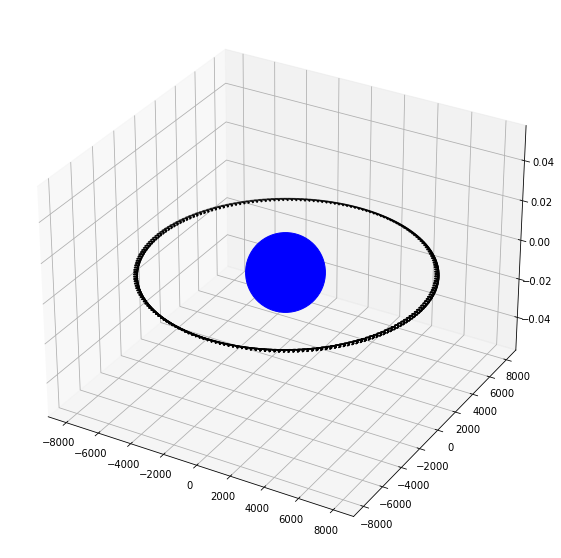

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r[::50,0], r[::50,1], r[::50,2],s=0.5,c='k') #xyz obviously
ax.scatter(0,0,0,c='blue',s=6370)

plt.show()

### Plotting groundtrack 

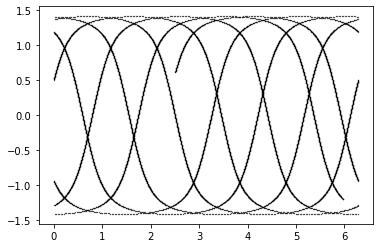

In [48]:
%matplotlib inline 
lons, lats = added_ctll.sats[-1].ssps(1,J2=True,drag=False)

fig = plt.figure()
plt.scatter(lons[::10],lats[::10],c='k',s=0.1)
plt.show()
 